In [1]:
import os
import git
import sys

git_repo = git.Repo(os.getcwd(), search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

sys.path.append(git_root)

from abm_vec.one_period_sim import run_sim, run_one_sim
from abm_vec.calibration import get_calibration_variables
from abm_vec.initialization import get_bank_data

from scipy.optimize import minimize
from scipy.stats import kstest
from scipy.stats import anderson_ksamp
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from abm_vec.essentials.util import get_git_root_directory
import numpy as np
import random
from scipy import stats
from joblib import Parallel, delayed

In [2]:
bank_data = get_bank_data()
calibration_variables = get_calibration_variables()

In [3]:
seeds = random.sample(range(1, 100000), 100)

In [4]:
# using the default distribution
results = run_one_sim(1, bank_data, calibration_variables)

In [5]:
empirical_le_ratio = results[0]['banks']['bank_loans'] / results[0]['banks']['bank_equity']
simulated_le_ratio = results[1]['banks']['bank_loans'] / results[0]['banks']['bank_equity']

In [6]:
sorted_empirical = np.sort(empirical_le_ratio)
sorted_simulated = np.sort(simulated_le_ratio)

n = empirical_le_ratio.size
ecdf = np.arange(1, n+1) / n

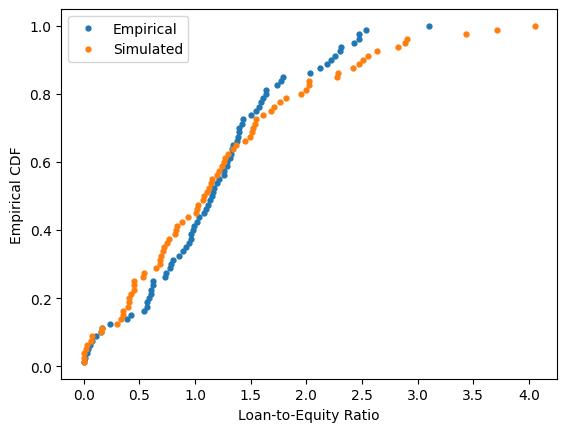

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Step 3: Plot the ECDF
plt.plot(sorted_empirical, ecdf, marker='.', linestyle='none', markersize=7, label='Empirical')
plt.plot(sorted_simulated, ecdf, marker='.', linestyle='none', markersize=7, label='Simulated')
plt.xlabel('Loan-to-Equity Ratio')
plt.ylabel('Empirical CDF')
plt.legend()
plt.savefig(os.path.join(git_root, 'plots_presentation/ecdf_calibration.png'),bbox_inches='tight', dpi=400, edgecolor='white')
plt.show()


In [17]:
# ks test
max_diff = kstest(empirical_le_ratio, simulated_le_ratio, alternative='two-sided').pvalue 
max_diff

0.6953371976633547

In [19]:
# generating 1000 scenarios
random_seeds = random.sample(range(1, 100000), 1000)
results = run_sim({}, copy.deepcopy(bank_data), random_seeds) 

In [20]:
empirical_le_ratio = [s[0]['banks']['bank_loans'] / s[0]['banks']['bank_equity'] for s in results]
simulated_le_ratio = [s[1]['banks']['bank_loans'] / s[0]['banks']['bank_equity'] for s in results]

In [23]:
res = anderson_ksamp(simulated_le_ratio)
res.pvalue

/tmp/ipykernel_8135/1268824115.py:1: UserWarning: p-value capped: true value larger than 0.25
  res = anderson_ksamp(simulated_le_ratio)


0.25

In [24]:
# ks test
res = [kstest(empirical_le_ratio[0], r, alternative='two-sided').pvalue for r in simulated_le_ratio]

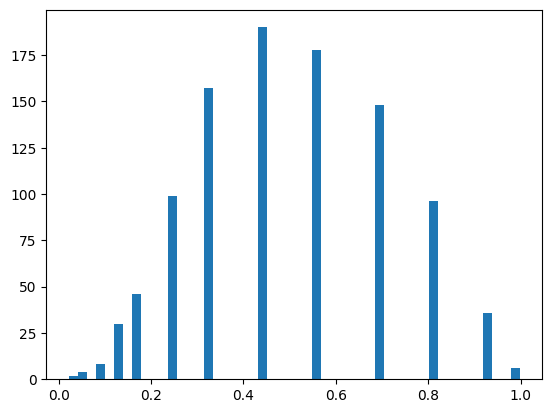

In [25]:
plt.hist(res, bins=50)
plt.show()

In [26]:
min(res)

0.021626029395464805